# Reinforcement Learning Trading Bot
An attempt at a reinforcement learning training bot. This is a work in progress, will update with more information and more complex models to try and improve it. (follow along from Nicholas Renotte ([link](https://www.youtube.com/channel/UCHXa4OpASJEwrHrLeIzw7Yg) to channel)).


## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# gym libraries
import gym
import gym_anytrading

# stable Baselines 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

C:\Users\midgl\anaconda3\envs\rltrader\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\midgl\anaconda3\envs\rltrader\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


## Load in Data
The data used for this notebook is for Amazon.com, Inc (AMZN) and it covers the time period 11/17/2020 - 11/17/2021 and was obtained from Market Watch ([link](https://www.marketwatch.com/investing/stock/amzn/download-data?startDate=11/18/2020&endDate=11/17/2021)).

We begin by loading in the data and prepping it.

In [2]:
df = pd.read_csv("data/amazondata.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,11/17/2021,"3,564.72","3,587.25","3,545.35","3,549.00","2,544,060"
1,11/16/2021,"3,539.00","3,576.50","3,525.15","3,540.70","2,217,071"
2,11/15/2021,"3,537.00","3,593.88","3,525.81","3,545.68","2,929,719"
3,11/12/2021,"3,485.00","3,540.73","3,447.05","3,525.15","2,689,434"
4,11/11/2021,"3,513.00","3,543.24","3,467.47","3,472.50","2,264,406"


In [4]:
df.dtypes

Date      object
Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

From the brief look at the data there are a few things that need to be addressed before continuing, and these are:
- For stable baselines to work the `Date` column needs to be in datetime format
- All other columns are objects, this is because each number contains a comma so this needs to be removed before converting to float for the RL model
- The `Date` column is also sorted with the most recent entry appearing first so this needs to be reversed

We begin by removing all commas and converting the `Date` column into the correct form

In [5]:
# remove commas
df = df.replace(',','', regex=True)

In [6]:
# convert all columns except Date into float
cols = list(df.columns)
cols.remove('Date')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# convert Date column into datetime
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

With this correctly done we correctly done we sort the date column

In [8]:
df.sort_values('Date', ascending=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
252,2020-11-17,3183.55,3189.25,3135.26,3135.66,3444735.0
251,2020-11-18,3134.00,3140.00,3105.10,3105.46,2916836.0
250,2020-11-19,3105.31,3125.00,3080.92,3117.02,3010270.0
249,2020-11-20,3117.02,3132.89,3098.05,3099.40,3380138.0
248,2020-11-23,3116.70,3139.75,3065.46,3098.39,4708887.0


Now all columns are in the correct format and the `Date` columns order has been reversed. Additionally stable baselines requires the `Date` column to be set as the index so lets do that.

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-17,3183.55,3189.25,3135.26,3135.66,3444735.0
2020-11-18,3134.00,3140.00,3105.10,3105.46,2916836.0
2020-11-19,3105.31,3125.00,3080.92,3117.02,3010270.0
2020-11-20,3117.02,3132.89,3098.05,3099.40,3380138.0
2020-11-23,3116.70,3139.75,3065.46,3098.39,4708887.0


Now the data is ready to be implemented into the gym environment.

## Loading the data into the gym environment

In [11]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,200), window_size=5)

To check to see if the environment has loaded correctly we will see how a trading bot would perform if it were to randomly put in Buy or Sell orders.

info {'total_reward': 26.13000000000102, 'total_profit': 0.4577800701671097, 'position': 1}


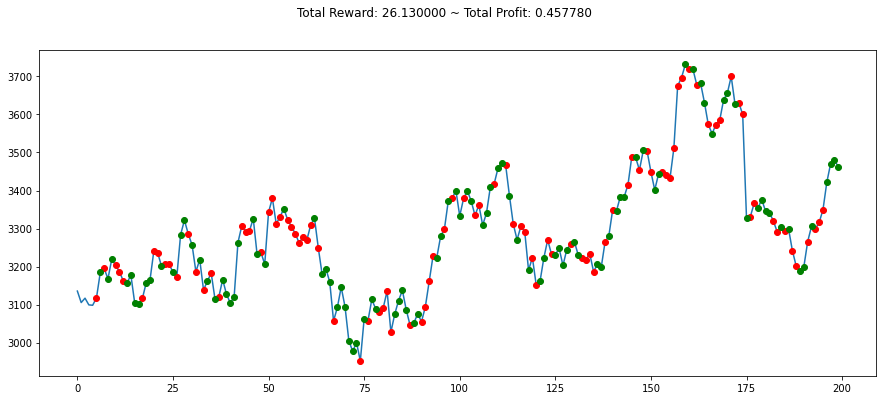

In [12]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Unsuprisingly a random trading bot is not effective and would have lost us over half of our original investment over 150 days. Let us see if we can improve this by using reinforcement learning.

## Creating and training RL model
Now lets see if we can create a model that performs better than the random trading bot using just reinforcement learning. First we create the environment and set the range we want the model to train over. For this I have started it from day 50 and it will train for 100 days until day 150.

In [13]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(50,150), window_size=5)
env = DummyVecEnv([env_maker])

The model we are using is A2C which is an actor critic method that uses multiple workers to avoid the use of a replay buffer ([Link to original paper](https://arxiv.org/abs/1602.01783)). 

In [14]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=50000, log_interval=2500)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | -145     |
| fps                | 28       |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 0.000593 |
---------------------------------
---------------------------------
| explained_variance | 0.162    |
| fps                | 1063     |
| nupdates           | 2500     |
| policy_entropy     | 0.147    |
| total_timesteps    | 12500    |
| value_loss         | 9.45e-06 |
---------------------------------
---------------------------------
| explained_variance | 0.711    |
| fps                | 1066    

Ideally with a succesful train we are looking for the `explained_variance` to increase and approach one at the end of training as this shows the model is beginning to recognise patterns. Unfortunately this does not happen for this model. Nevertheless we will test it over the 20 days following the inital training range to see how it performs.

In [15]:
env = gym.make('stocks-v0', df=df, frame_bound=(150,175), window_size=5)
obs = env.reset()
while True:
    obs = obs[np.newaxis,...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 77.14000000000078, 'total_profit': 0.9474611778469194, 'position': 0}


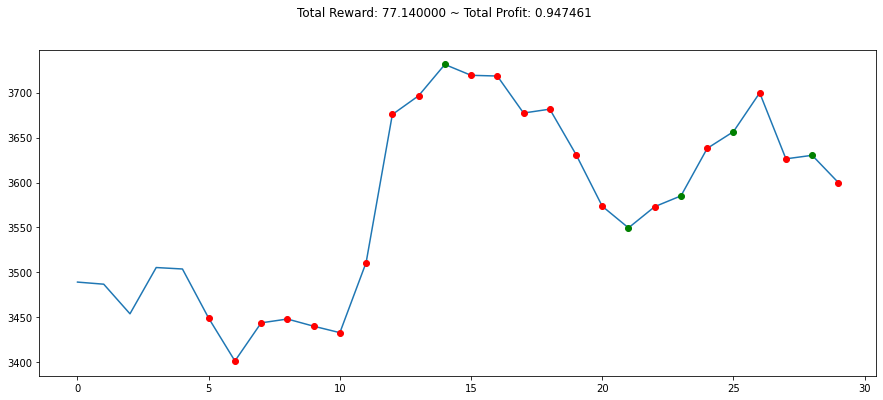

In [16]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Despite the initial concerns regarding the models low `explained_variance` it performs okay. It does report a 5% loss over 20 days but given the simplicity of the model I would say this is good. The next step is to add custom indicators into the model to try and improve its performance.


# Reinforcement Learning Trading Bot with Custom Indicators 
To add indicators to the model we will need additional modules. StocksEnv will allow us to include indicators in the model. Finta is a financial technical analysis module and will calculate the indicators for us.
## Import further dependencies

In [17]:
from gym_anytrading.envs import StocksEnv
from finta import TA

## Calculate Custom Indicators
The indicators that we will include in the model are:
- Simple Moving Average
- Relative Strength Index
- On Balance Volume

In [18]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)

In [19]:
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-11-17,3183.55,3189.25,3135.26,3135.66,3444735.0,NaN,NaN,NaN
2020-11-18,3134.00,3140.00,3105.10,3105.46,2916836.0,NaN,0.000000,-2916836.0
2020-11-19,3105.31,3125.00,3080.92,3117.02,3010270.0,NaN,29.189813,93434.0
2020-11-20,3117.02,3132.89,3098.05,3099.40,3380138.0,NaN,19.734290,-3286704.0
2020-11-23,3116.70,3139.75,3065.46,3098.39,4708887.0,NaN,19.347409,-7995591.0


There are some NaN values now present so these need to replaced with 0

In [20]:
df.fillna(0, inplace=True)
df.head()

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-11-17,3183.55,3189.25,3135.26,3135.66,3444735.0,0.0,0.000000,0.0
2020-11-18,3134.00,3140.00,3105.10,3105.46,2916836.0,0.0,0.000000,-2916836.0
2020-11-19,3105.31,3125.00,3080.92,3117.02,3010270.0,0.0,29.189813,93434.0
2020-11-20,3117.02,3132.89,3098.05,3099.40,3380138.0,0.0,19.734290,-3286704.0
2020-11-23,3116.70,3139.75,3065.46,3098.39,4708887.0,0.0,19.347409,-7995591.0


## Adding Signals to the Gym Environment
Now we add the indicators to the reinforcement learning model and set up the gym environment over the same days as the previous model

In [21]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [22]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(50,150))

In [23]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

## Training the New Model
After some testing it became apparent that the RL model including indicators required longer to train as this improved results. A longer training time for the basic model resulted in worse performance.

In [24]:
model = A2C('MlpLstmPolicy', env, verbose=1)
model.learn(total_timesteps=500000, log_interval=10000)

---------------------------------
| explained_variance | -276     |
| fps                | 31       |
| nupdates           | 1        |
| policy_entropy     | 0.691    |
| total_timesteps    | 5        |
| value_loss         | 0.000152 |
---------------------------------
---------------------------------
| explained_variance | -68.7    |
| fps                | 1065     |
| nupdates           | 10000    |
| policy_entropy     | 0.164    |
| total_timesteps    | 50000    |
| value_loss         | 881      |
---------------------------------
---------------------------------
| explained_variance | 0.388    |
| fps                | 1061     |
| nupdates           | 20000    |
| policy_entropy     | 0.295    |
| total_timesteps    | 100000   |
| value_loss         | 1.98e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 1066     |
| nupdates           | 30000    |
| policy_entropy     | 0.00192  |
| total_timest

## Evaluating the New Model
Looking at the `explained_variance` its clear that this model performs better as it actually approaches 1 and stays there. Let us now check the performance of the model to see how well it does on the same test data as before.

In [25]:
env = MyCustomEnv(df=df, frame_bound=(150,175), window_size=12)
obs = env.reset()
while True:
    obs = obs[np.newaxis,...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 217.3100000000004, 'total_profit': 1.0323987745850138, 'position': 0}


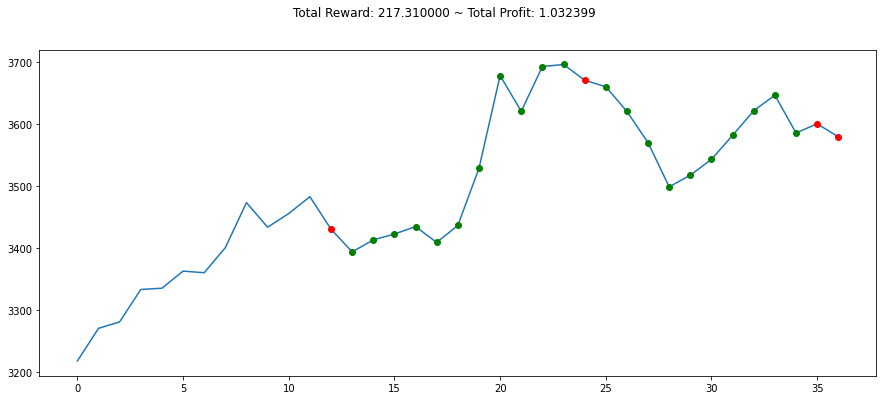

In [26]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Now we finally get a profit of 3% over 20 days. Not bad for a simple RL bot trained in a couple of minutes.

## Final Thoughts
We began this notebook by setting up a random trading bot, this did not perform well and would have lost someone a significant amount of money. We then used reinforcement learning to create a trading bot. This performed a lot better only losing us 4% (although this was over a smaller time period). The next step was including custom indicators into the model. This performed even better resulting in a profit of ??%. This is still a long way off being implemented in a real setting but for some improvements I will work on include:

- Using stable_baselines3 which uses PyTorch and does not use an old version of TensorFlow
- Trying different reinforcement learning algorithms to see if it's affect on performance
- Trying different indicators to see affect on performance
- Trying differnt frequency of stock updates (hourly, minute by minute)
- Including more information regarding indicators and reasons for choosing them

Following this I will then test the final model using a practice trading account to see its performance.

If you got this far thank you for reading through :) If you have any suggestions please say as I am still learning.